### Введение к проекту

Интернет-магазины ежедневно сталкиваются с необходимостью анализа поведения клиентов для оптимизации своих маркетинговых кампаний. История покупок, рассылки предложений и планирование будущих продаж играют ключевую роль в увеличении выручки и снижении издержек.  

Данный проект направлен на решение задачи **выделения клиентов, которые готовы совершить покупку в ближайшее время**.  

#### Зачем это важно?
- **Оптимизация маркетингового бюджета**: Фокус на клиентах, требующих дополнительного стимулирования.
- **Снижение издержек**: Избежание лишних затрат на тех, кто уже склонен к покупке.
- **Повышение эффективности продаж**: Точное понимание целевой аудитории позволяет улучшить конверсию.

---

#### Что будет сделано?
Используя данные о поведении пользователей и исторические метрики, мы разработаем модель машинного обучения, способную прогнозировать вероятность совершения покупки. Это станет важным инструментом для поддержки маркетинговых решений и повышения эффективности бизнес-процессов.


In [625]:
pip install dask[dataframe]

# Импорт датафреймов

In [671]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [627]:
try:
    messages = pd.read_csv('apparel-messages.csv')
except FileNotFoundError:
    print("Файл 'apparel-messages.csv' не найден.")

try:
    purchases = pd.read_csv('apparel-purchases.csv')
except FileNotFoundError:
    print("Файл 'apparel-purchases.csv' не найден.")

try:
    target = pd.read_csv('apparel-target_binary.csv')
except FileNotFoundError:
    print("Файл 'apparel-target_binary.csv' не найден.")

try:
    daily_event = pd.read_csv('full_campaign_daily_event.csv')
except FileNotFoundError:
    print("Файл 'full_campaign_daily_event.csv' не найден.")

try:
    event_channel = pd.read_csv('full_campaign_daily_event_channel.csv')
except FileNotFoundError:
    print("Файл 'full_campaign_daily_event_channel.csv' не найден.")


# Предварительный анализ

## Обработка числовых данных для оптимизации памяти

In [628]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [629]:
# Оптимизация памяти для всех DataFrame
messages = optimize_memory_usage(messages)
purchases = optimize_memory_usage(purchases)
target = optimize_memory_usage(target)
daily_event = optimize_memory_usage(daily_event)
event_channel = optimize_memory_usage(event_channel)

Размер использования памяти: до 139.26 Mb - после 124.34 Mb (10.7%)
Размер использования памяти: до  9.26 Mb - после  7.14 Mb (22.9%)
Размер использования памяти: до  0.76 Mb - после  0.43 Mb (43.7%)
Размер использования памяти: до 24.00 Mb - после  9.50 Mb (60.4%)
Размер использования памяти: до 36.00 Mb - после 14.50 Mb (59.7%)


## Структура и типы данных

In [630]:
display(messages.head(),
        target.head(),
        daily_event.head(),
        event_channel.head(),
        purchases.head()
        )

display(messages.info(),
        target.info(),
        daily_event.info(),
        event_channel.info(),
        purchases.info()
        )

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2607527 entries, 0 to 2607526
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int16 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int16(1), int64(1), object(5)
memory usage: 124.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int8 
dtypes: int64(1), int8(1)
memory usage: 438.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non

None

None

None

None

None

### Обработка столбца date во всех датафреймах

In [631]:
# Преобразуем столбец 'date' в формат datetime во всех DataFrame
messages['date'] = pd.to_datetime(messages['date'], errors='coerce')
purchases['date'] = pd.to_datetime(purchases['date'], errors='coerce')
daily_event['date'] = pd.to_datetime(daily_event['date'], errors='coerce')
event_channel['date'] = pd.to_datetime(event_channel['date'], errors='coerce')

## Проверка пропусков в датафреймах

In [632]:
def check_missing_values(df, df_name):
    """Функция для проверки пропусков в DataFrame."""
    if df is not None:
        missing_values = df.isnull().sum()
        print(f"Пропуски в {df_name}:")
        print(missing_values[missing_values > 0])  # Выводим только столбцы с пропусками
        print("\n" + "-" * 50)
    else:
        print(f"DataFrame {df_name} не был загружен.\n" + "-" * 50)

# Проверяем каждый DataFrame на пропуски
check_missing_values(messages, "messages")
check_missing_values(purchases, "purchases")
check_missing_values(target, "target")
check_missing_values(daily_event, "daily_event")
check_missing_values(event_channel, "event_channel")

Пропуски в messages:
event         1
channel       1
date          1
created_at    1
dtype: int64

--------------------------------------------------
Пропуски в purchases:
Series([], dtype: int64)

--------------------------------------------------
Пропуски в target:
Series([], dtype: int64)

--------------------------------------------------
Пропуски в daily_event:
Series([], dtype: int64)

--------------------------------------------------
Пропуски в event_channel:
Series([], dtype: int64)

--------------------------------------------------


In [633]:
# Вывод строки с пропусками для messages
display(messages[messages.isnull().any(axis=1)])


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
2607526,7759,1515915625752561780,151,NaN,NaN,NaT,NaN


Одна строка в датафрейме messages содержит пропуски

## Проверка на дубликаты

In [634]:
print('Количество дубликатов -', messages.duplicated().sum())
print('Количество уникальных клиентов -',messages['client_id'].nunique())


Количество дубликатов - 41
Количество уникальных клиентов - 41370


In [635]:
print('Количество дубликатов -', purchases.duplicated().sum())
print('Количество уникальных клиентов -',purchases['client_id'].nunique())
print('Количество уникальных category_ids -',purchases['category_ids'].nunique())

Количество дубликатов - 73020
Количество уникальных клиентов - 49849
Количество уникальных category_ids - 933


Вывод, каждая покупка записывается отдельной строкой, даже если был куплен один и тот же товар несколько раз. Все значения кроме 1 либо ошибка, либо товары, которые не продаются штучно.

In [676]:
display(target.head())

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [677]:
target['target'].value_counts()

,count
target,
0,48888
1,961


Сильный дисбаланс классов

# Анализ и группировка данных

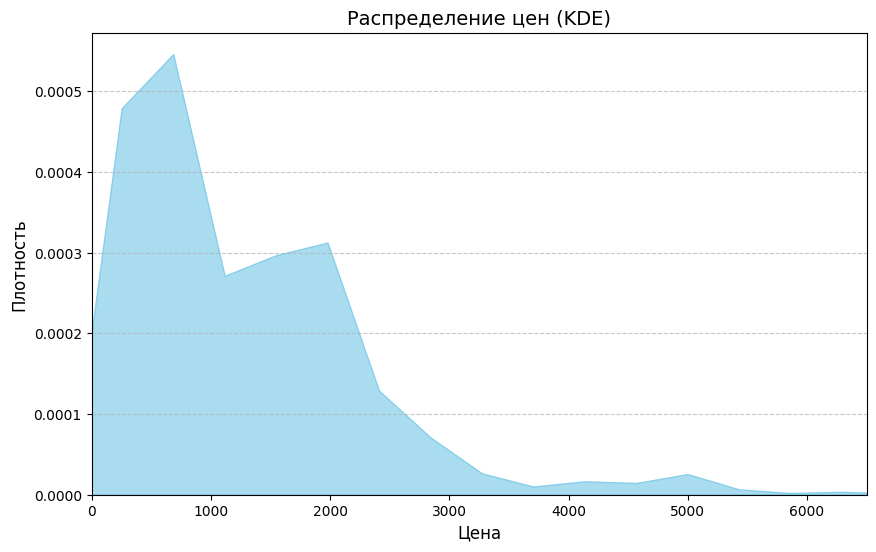

In [636]:
# Построение KDE графика
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=purchases,
    x='price',
    fill=True,  # Закрашиваем под кривой
    color='skyblue',
    alpha=0.7,
    bw_adjust=0.5  # Регулируем степень сглаживания
)

# Настраиваем оси и заголовки
plt.title('Распределение цен (KDE)', fontsize=14)
plt.xlabel('Цена', fontsize=12)
plt.ylabel('Плотность', fontsize=12)

# Ограничиваем ось x, если есть выбросы
plt.xlim(0, purchases['price'].quantile(0.995))  # Обрезаем 0.5% выбросов сверху для наглядности

# Отображаем график
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## purchases

### Группировка датафрейма purchases

In [637]:
# Группируем данные purchases по client_id и добавляем столбец с датой последней покупки
grouped_purchases = purchases.groupby('client_id').agg({
        'quantity': 'sum',  # Суммируем количество товаров
        'price': 'mean',    # Средняя цена товара
        'category_ids': 'nunique',  # Считаем количество уникальных категорий
        'date': ['min', 'max'],  # Находим дату первой и последней покупки
        'message_id': 'nunique'  # Уникальные сообщения
    }).reset_index()

# Объединяем уровни колонок после группировки
grouped_purchases.columns = ['client_id', 'total_quantity', 'average_price', 'unique_items', 'first_purchase_date', 'last_purchase_date', 'unique_messages']

# Результат
display(grouped_purchases.head())

,client_id,total_quantity,average_price,unique_items,first_purchase_date,last_purchase_date,unique_messages
0,1515915625468060902,7,999.000000,5,2022-05-27,2022-05-27,1
1,1515915625468061003,7,2319.285645,1,2023-01-04,2023-01-04,1
2,1515915625468061099,1,299.000000,1,2022-05-17,2022-05-17,1
3,1515915625468061100,2,1049.000000,1,2024-02-10,2024-02-10,1
4,1515915625468061170,19,1768.473633,4,2023-03-26,2023-06-17,3


In [638]:
grouped_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   client_id            49849 non-null  int64         
 1   total_quantity       49849 non-null  int64         
 2   average_price        49849 non-null  float32       
 3   unique_items         49849 non-null  int64         
 4   first_purchase_date  49849 non-null  datetime64[ns]
 5   last_purchase_date   49849 non-null  datetime64[ns]
 6   unique_messages      49849 non-null  int64         
dtypes: datetime64[ns](2), float32(1), int64(4)
memory usage: 2.5 MB


## messages

### Создание признака duration в messages

In [639]:
# Находим последнюю дату в столбце last_purchase_date
last_date = grouped_purchases['last_purchase_date'].max()
print(f"Дата последнего заказа: {last_date.date()}")


# Вычисляем период покупок для каждого клиента
grouped_purchases['duration'] = (grouped_purchases['last_purchase_date'] - grouped_purchases['first_purchase_date']).dt.days
# Если клиент совершил покупку только один раз, устанавливаем duration = 1
grouped_purchases['duration'] = grouped_purchases['duration'].apply(lambda x: x if x > 0 else 1)

# Удаляем first_purchase_date и last_purchase_date так как они отражены в duration
grouped_purchases.drop(['first_purchase_date', 'last_purchase_date'], axis=1, inplace=True)

# Результат: выводим весь DataFrame с новым столбцом
display(grouped_purchases.head())

Дата последнего заказа: 2024-02-16


,client_id,total_quantity,average_price,unique_items,unique_messages,duration
0,1515915625468060902,7,999.000000,5,1,1
1,1515915625468061003,7,2319.285645,1,1,1
2,1515915625468061099,1,299.000000,1,1,1
3,1515915625468061100,2,1049.000000,1,1,1
4,1515915625468061170,19,1768.473633,4,3,83


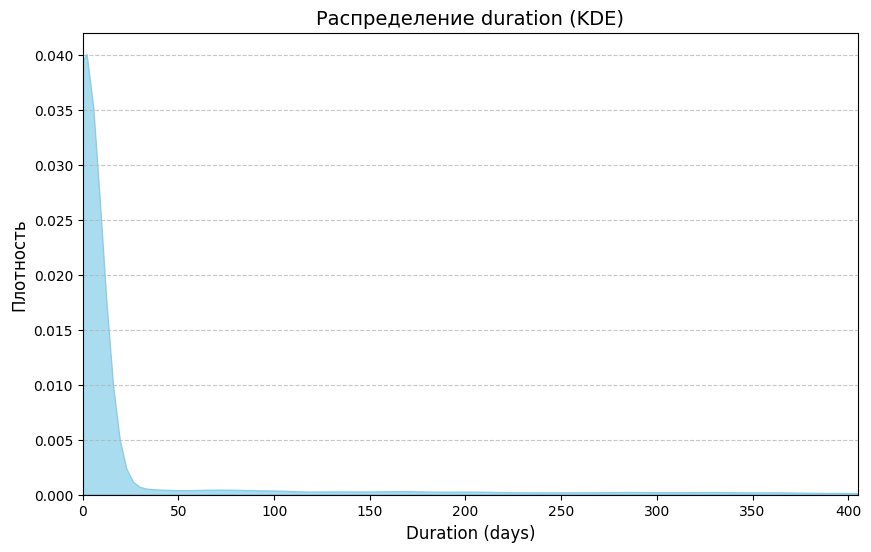

In [640]:
# Построение KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(grouped_purchases['duration'], fill=True, color='skyblue', alpha=0.7)

# Настройка осей и заголовка
plt.title('Распределение duration (KDE)', fontsize=14)
plt.xlabel('Duration (days)', fontsize=12)
plt.ylabel('Плотность', fontsize=12)

# Вычисляем 99.5-й перцентиль
x_limit = grouped_purchases['duration'].quantile(0.99)
# Ограничение xlim
plt.xlim(0, x_limit)

# Отображение графика
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [641]:
display(messages.head())
messages.info()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2607527 entries, 0 to 2607526
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int16         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        object        
dtypes: datetime64[ns](1), int16(1), int64(1), object(4)
memory usage: 124.3+ MB


### Категоризация event в messages


In [642]:
messages['event'].value_counts()

,count
event,
send,1837300
open,564373
click,170747
purchase,28443
hard_bounce,4038
soft_bounce,1589
unsubscribe,692
hbq_spam,323
subscribe,21


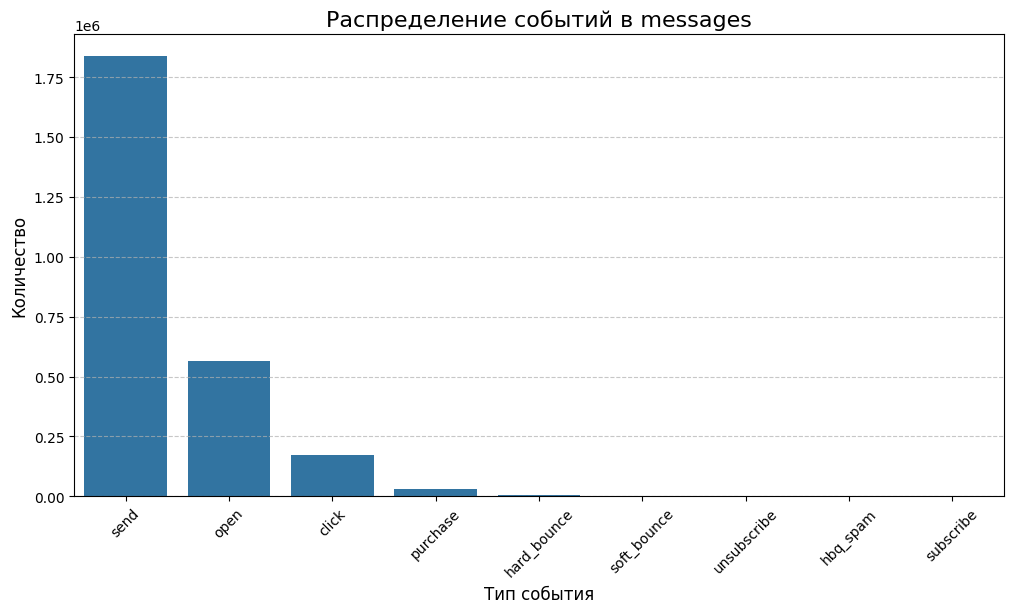

In [643]:
# Подсчитываем количество событий
event_counts = messages['event'].value_counts()

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 6))
sns.barplot(x=event_counts.index, y=event_counts.values)

# Настройка графика
plt.title('Распределение событий в messages', fontsize=16)
plt.xlabel('Тип события', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=45, fontsize=10)  # Поворот меток для удобства чтения
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отображение графика
plt.show()

In [644]:
# Значения из value_counts
send_count = messages['event'].value_counts().get('send', 0)  # Количество send
purchase_count = messages['event'].value_counts().get('purchase', 0)  # Количество purchase

# Расчёт конверсии
conversion_rate = (purchase_count / send_count) * 100 if send_count > 0 else 0
print(f"Конверсия send → purchase: {conversion_rate:.2f}%")

Конверсия send → purchase: 1.55%


In [645]:
# Определяем категории для каждого события
positive_events = {'open', 'click', 'purchase', 'subscribe'}
neutral_events = {'send'}
negative_events = {'hard_bounce', 'soft_bounce', 'unsubscribe', 'complain', 'hbq_spam'}

# Функция для классификации событий
def categorize_event(event):
    if event in positive_events:
        return '3'
    elif event in neutral_events:
        return '2'
    elif event in negative_events:
        return '1'
    else:
        return 'unknown'

# Применяем функцию к столбцу event и создаем новый столбец event_type
messages['event_type'] = messages['event'].apply(categorize_event)

# Убеждаемся, что столбец числовой
messages['event_type'] = pd.to_numeric(messages['event_type'], errors='coerce')


# Результат
display(messages.head())

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,event_type
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,3.0
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,3.0
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49,3.0
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20,3.0
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52,3.0


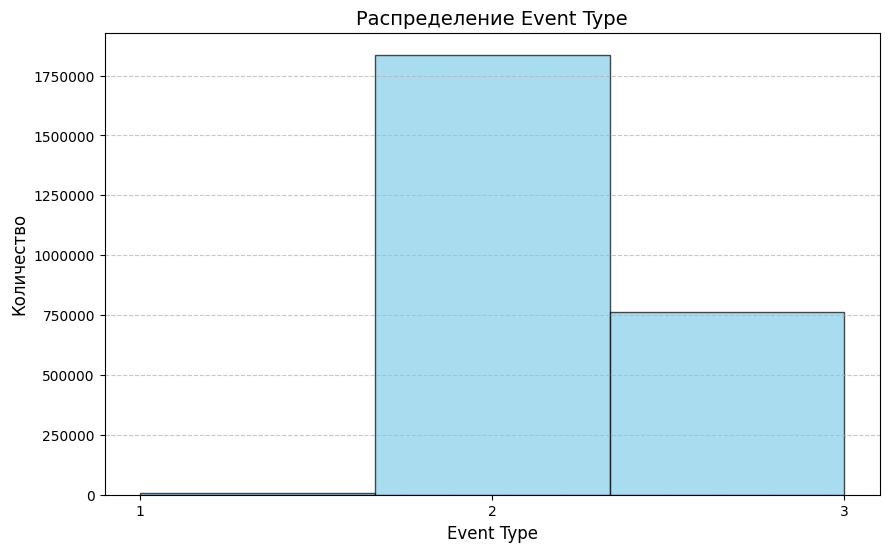

In [646]:
# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.hist(messages['event_type'], bins=3, color='skyblue', edgecolor='black', alpha=0.7)

# Настройка графика
plt.title('Распределение Event Type', fontsize=14)
plt.xlabel('Event Type', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks([1, 2, 3])

# Отображение графика
plt.show()

Наблюдается значительный диссбаланс данных

In [647]:
messages['channel'].value_counts()

,count
channel,
email,1717681
mobile_push,889845


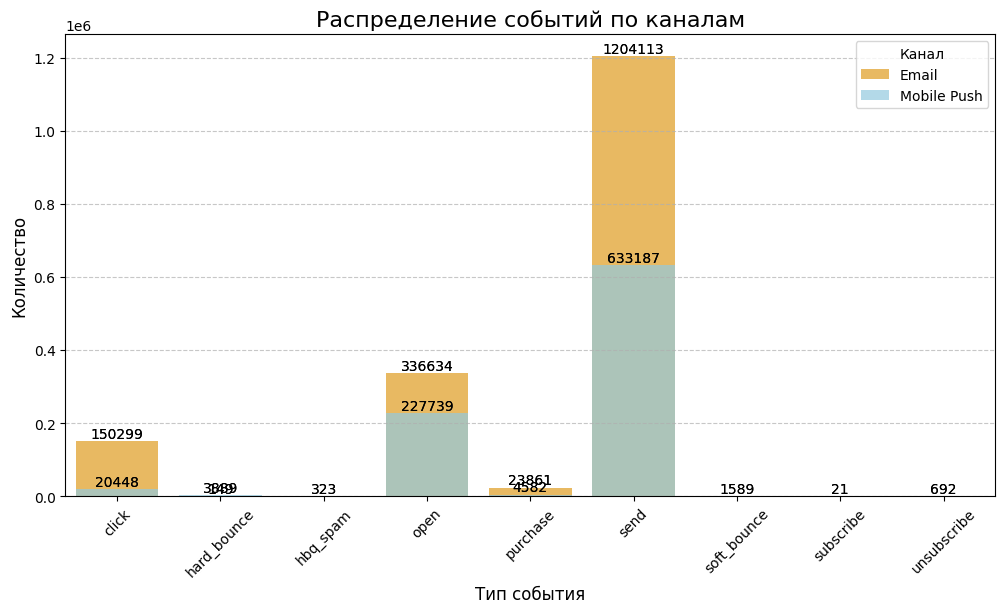

In [648]:
# Группируем данные по channel и event, подсчитываем количество событий
grouped_m = messages.groupby(['channel', 'event']).size().reset_index(name='count')

# Разделение данных по каналам
email_events = grouped_m[grouped_m['channel'] == 'email']
mobile_events = grouped_m[grouped_m['channel'] == 'mobile_push']

# Построение графика с наложением
plt.figure(figsize=(12, 6))
bar1 = sns.barplot(data=email_events, x='event', y='count', color='orange', alpha=0.7, label='Email')
bar2 = sns.barplot(data=mobile_events, x='event', y='count', color='skyblue', alpha=0.7, label='Mobile Push')

# Добавляем подписи к столбцам
for bar in bar1.containers + bar2.containers:  # Проходим по контейнерам столбцов
    bar_labels = [f'{int(val)}' for val in bar.datavalues]  # Форматируем значения
    bar.datavalues  # Получаем высоты столбцов
    plt.bar_label(bar, labels=bar_labels, label_type='edge', fontsize=10)

# Настройка графика
plt.title('Распределение событий по каналам', fontsize=16)
plt.xlabel('Тип события', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Канал')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отображение графика
plt.show()


In [649]:
# Получаем данные для каждого канала
email_data = grouped_m[grouped_m['channel'] == 'email']
mobile_data = grouped_m[grouped_m['channel'] == 'mobile_push']

# Извлекаем количество send и purchase для каждого канала
email_send = email_data[email_data['event'] == 'send']['count'].values[0]
email_purchase = email_data[email_data['event'] == 'purchase']['count'].values[0]
mobile_send = mobile_data[mobile_data['event'] == 'send']['count'].values[0]
mobile_purchase = mobile_data[mobile_data['event'] == 'purchase']['count'].values[0]

# Расчёт конверсии
email_conversion = (email_purchase / email_send) * 100 if email_send > 0 else 0
mobile_conversion = (mobile_purchase / mobile_send) * 100 if mobile_send > 0 else 0

# Вывод результатов
print(f"Конверсия send → purchase для email: {email_conversion:.2f}%")
print(f"Конверсия send → purchase для mobile_push: {mobile_conversion:.2f}%")

Конверсия send → purchase для email: 1.98%
Конверсия send → purchase для mobile_push: 0.72%


### Создание признаков email_conversion и mobile_conversion в messages для каждого пользователя

In [650]:
# Фильтруем данные по событиям send и purchase
send_data = messages[messages['event'] == 'send']
purchase_data = messages[messages['event'] == 'purchase']

# Подсчитываем количество send и purchase для каждого client_id и channel
send_counts = send_data.groupby(['client_id', 'channel']).size().unstack(fill_value=0)
purchase_counts = purchase_data.groupby(['client_id', 'channel']).size().unstack(fill_value=0)

# Вычисляем конверсии для каждого client_id
conversion = purchase_counts / send_counts
conversion = conversion.fillna(0)  # Заполняем NaN для случаев, где не было send или purchase

# Добавляем конверсии в messages
messages['mobile_conversion'] = messages['client_id'].map(conversion['mobile_push'] if 'mobile_push' in conversion else 0)
messages['email_conversion'] = messages['client_id'].map(conversion['email'] if 'email' in conversion else 0)
display(messages.head())

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,event_type,mobile_conversion,email_conversion
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,3.0,0.0,0.000000
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,3.0,0.0,0.000000
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49,3.0,0.0,0.076923
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20,3.0,0.0,0.076923
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52,3.0,0.0,0.000000


In [651]:
# Избавимся от бесконечностей, чтобы в дальнейшем не мешали при обучении моделей
# Вычисляем среднее значение столбца 'email_conversion', игнорируя inf и -inf
mean_value = messages.loc[~np.isinf(messages['email_conversion']), 'email_conversion'].mean()

# Заменяем inf и -inf на вычисленное среднее
messages['email_conversion'] = messages['email_conversion'].replace([np.inf, -np.inf], mean_value)

In [652]:
# Подсчёт количества нулей в каждом столбце
mobile_conversion_zeros = (messages['mobile_conversion'] == 0).sum()
email_conversion_zeros = (messages['email_conversion'] == 0).sum()

# Вывод результатов
print(f"Количество нулей в mobile_conversion: {mobile_conversion_zeros}")
print(f"Количество нулей в email_conversion: {email_conversion_zeros}")


Количество нулей в mobile_conversion: 2408517
Количество нулей в email_conversion: 1521199


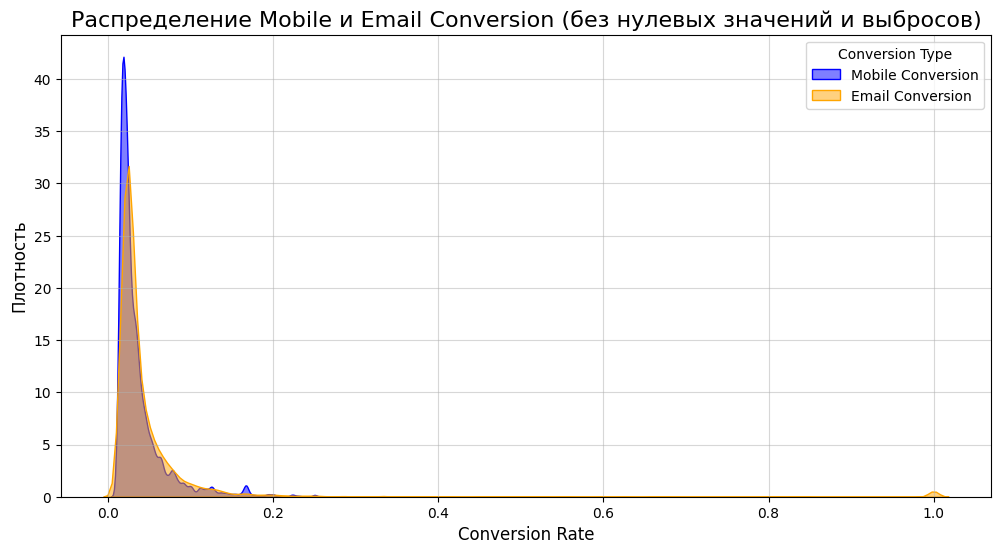

In [653]:
# Фильтрация данных: исключаем нулевые значения
mobile_conversion_nonzero = messages[messages['mobile_conversion'] > 0]['mobile_conversion']
email_conversion_nonzero = messages[messages['email_conversion'] > 0]['email_conversion']

# Удаляем верхние 0.5% выбросов
mobile_upper_limit = mobile_conversion_nonzero.quantile(0.99)
email_upper_limit = email_conversion_nonzero.quantile(0.99)

mobile_conversion_filtered = mobile_conversion_nonzero[mobile_conversion_nonzero <= mobile_upper_limit]
email_conversion_filtered = email_conversion_nonzero[email_conversion_nonzero <= email_upper_limit]

# Построение графиков плотности (KDE)
plt.figure(figsize=(12, 6))
sns.kdeplot(mobile_conversion_filtered, fill=True, color='blue', alpha=0.5, label='Mobile Conversion')
sns.kdeplot(email_conversion_filtered, fill=True, color='orange', alpha=0.5, label='Email Conversion')

# Настройка графика
plt.title('Распределение Mobile и Email Conversion (без нулевых значений и выбросов)', fontsize=16)
plt.xlabel('Conversion Rate', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend(title='Conversion Type', fontsize=10)
plt.grid(alpha=0.5)

# Отображение графика
plt.show()

### Группировка датафрейма messages

In [654]:
# Группируем данные по client_id и вычисляем метрики
grouped_messages = messages.groupby('client_id').agg({
    'bulk_campaign_id': 'nunique',  # Количество уникальных кампаний
    'message_id': 'count',          # Общее количество сообщений
    'event_type': 'median',         # Медианное значение event_type
    'channel': 'nunique',           # Количество уникальных каналов
    'date': ['min', 'max'],         # Даты первого и последнего события
    'mobile_conversion': 'first',   # Значение mobile_conversion (берём любое ненулевое, так как оно одинаково)
    'email_conversion': 'first'     # Значение email_conversion
}).reset_index()

# Упрощаем названия столбцов после группировки
grouped_messages.columns = [
    'client_id',
    'unique_campaigns',
    'total_messages',
    'event_type_median',
    'unique_channels',
    'first_event_date',
    'last_event_date',
    'mobile_conversion',
    'email_conversion'
]

# Результат
display(grouped_messages.head())

,client_id,unique_campaigns,total_messages,event_type_median,unique_channels,first_event_date,last_event_date,mobile_conversion,email_conversion
0,1515915625468060902,40,69,2.0,1,2022-05-19,2022-11-15,0.0,0.128205
1,1515915625468061003,43,44,2.0,1,2022-05-20,2022-11-16,0.0,0.000000
2,1515915625468061099,86,114,2.0,2,2022-05-19,2022-11-17,0.0,0.000000
3,1515915625468061100,55,55,2.0,1,2022-05-19,2022-11-16,0.0,0.000000
4,1515915625468061170,32,52,2.0,1,2022-05-25,2022-11-16,0.0,0.000000


In [678]:
grouped_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41370 entries, 0 to 41369
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_id          41370 non-null  int64  
 1   unique_campaigns   41370 non-null  int64  
 2   total_messages     41370 non-null  int64  
 3   event_type_median  41370 non-null  float64
 4   unique_channels    41370 non-null  int64  
 5   mobile_conversion  41365 non-null  float64
 6   email_conversion   41365 non-null  float64
 7   events_duration    41370 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 2.5 MB


In [656]:
grouped_messages['event_type_median'].value_counts()

,count
event_type_median,
2.0,35104
3.0,5572
2.5,620
1.5,72
1.0,2


### Создание признака event_duration

In [657]:
# Вычисляем разницу между последней и первой датами событий
grouped_messages['events_duration'] = (grouped_messages['last_event_date'] - grouped_messages['first_event_date']).dt.days

# Удаляем first_event_date и last_event_date из grouped_messages
grouped_messages.drop(['first_event_date', 'last_event_date'], axis=1, inplace=True)

# Результат
display(grouped_messages.head())


,client_id,unique_campaigns,total_messages,event_type_median,unique_channels,mobile_conversion,email_conversion,events_duration
0,1515915625468060902,40,69,2.0,1,0.0,0.128205,180
1,1515915625468061003,43,44,2.0,1,0.0,0.000000,180
2,1515915625468061099,86,114,2.0,2,0.0,0.000000,182
3,1515915625468061100,55,55,2.0,1,0.0,0.000000,181
4,1515915625468061170,32,52,2.0,1,0.0,0.000000,175


# Объединение датафреймов

In [658]:
# Объединяем таблицу purchases с target
merged_data = grouped_purchases.merge(target, on='client_id', how='inner')
# Объединяем результат с messages
merged_data = merged_data.merge(grouped_messages, on='client_id', how='left')
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_id          49849 non-null  int64  
 1   total_quantity     49849 non-null  int64  
 2   average_price      49849 non-null  float32
 3   unique_items       49849 non-null  int64  
 4   unique_messages    49849 non-null  int64  
 5   duration           49849 non-null  int64  
 6   target             49849 non-null  int8   
 7   unique_campaigns   35662 non-null  float64
 8   total_messages     35662 non-null  float64
 9   event_type_median  35662 non-null  float64
 10  unique_channels    35662 non-null  float64
 11  mobile_conversion  35658 non-null  float64
 12  email_conversion   35658 non-null  float64
 13  events_duration    35662 non-null  float64
dtypes: float32(1), float64(7), int64(5), int8(1)
memory usage: 4.8 MB


не все client_id в датафреймах messages и target совпадают

In [659]:
# Проверяем пропущенные значения
missing_values = merged_data.isnull().sum()

# Выводим только те столбцы, где есть пропуски
missing_columns = missing_values[missing_values > 0]

print("Пропущенные значения в датафрейме:")
print(missing_columns if not missing_columns.empty else "Пропущенных значений нет")

Пропущенные значения в датафрейме:
unique_campaigns     14187
total_messages       14187
event_type_median    14187
unique_channels      14187
mobile_conversion    14191
email_conversion     14191
events_duration      14187
dtype: int64


In [660]:
# Замена всех пропущенных значений на 0
merged_data = merged_data.fillna(0)

In [661]:
merged_data.head()

,client_id,total_quantity,average_price,unique_items,unique_messages,duration,target,unique_campaigns,total_messages,event_type_median,unique_channels,mobile_conversion,email_conversion,events_duration
0,1515915625468060902,7,999.000000,5,1,1,0,40.0,69.0,2.0,1.0,0.0,0.128205,180.0
1,1515915625468061003,7,2319.285645,1,1,1,1,43.0,44.0,2.0,1.0,0.0,0.000000,180.0
2,1515915625468061099,1,299.000000,1,1,1,0,86.0,114.0,2.0,2.0,0.0,0.000000,182.0
3,1515915625468061100,2,1049.000000,1,1,1,0,55.0,55.0,2.0,1.0,0.0,0.000000,181.0
4,1515915625468061170,19,1768.473633,4,3,83,0,32.0,52.0,2.0,1.0,0.0,0.000000,175.0


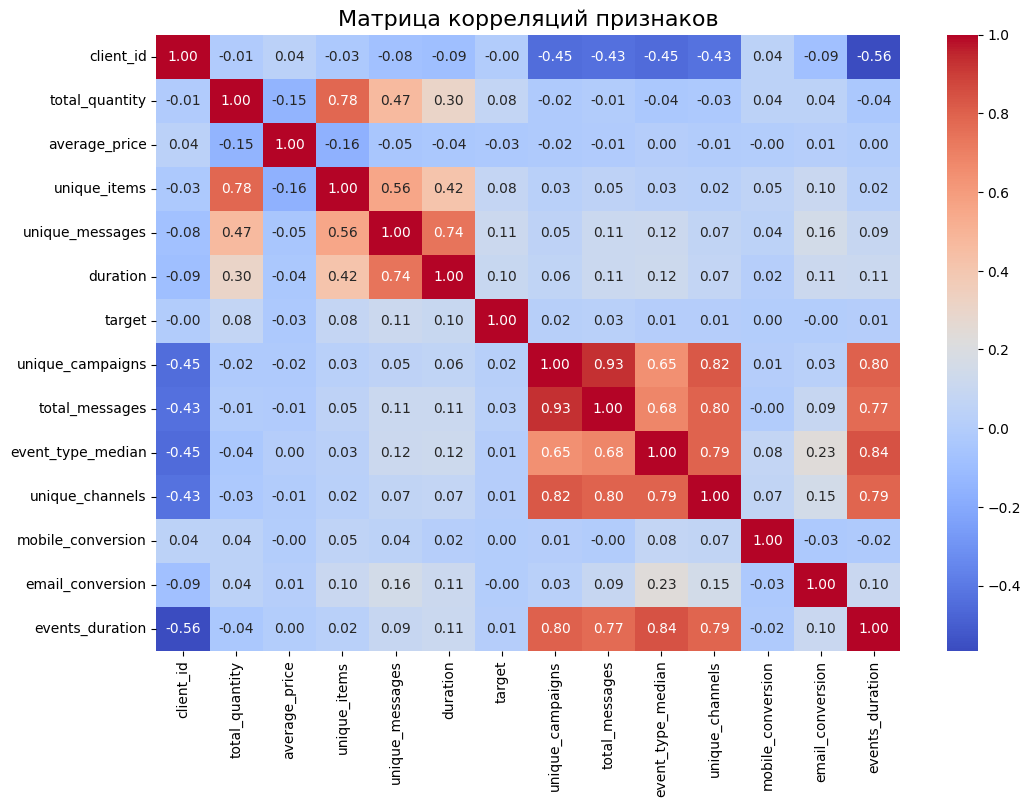

In [662]:
# Расчёт корреляционной матрицы для числовых столбцов
correlation_matrix = merged_data.corr()

# Построение тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Настройка графика
plt.title('Матрица корреляций признаков', fontsize=16)
plt.show()

unique_campaigns и total_messages показывают высокю корреляцию. Предпологаю, что столбец unique_campaigns будет полезно удалить.

In [663]:
# Удаление столбца с высокой корреляцией
merged_data = merged_data.drop(columns=['unique_campaigns','event_type_median', 'unique_channels'])


# Обучение и тестировка моделей

## Разделение выборок и определение признаков

In [664]:
# Разделение на признаки и целевую переменную
X = merged_data.drop(columns=['client_id', 'target'])
y = merged_data['target']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Параметры для RandomizedSearch

In [665]:
# Параметры для RandomizedSearch
knn_params = {
    'knn__n_neighbors': [9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

tree_params = {
    'tree__max_depth': [5],
    'tree__min_samples_split': [10],
    'tree__min_samples_leaf': [2]
}

lgbm_params = {
    'lgbm__num_leaves': [5],
    'lgbm__learning_rate': [0.2],
    'lgbm__n_estimators': [30]
}

## Создание пайплайнов

In [666]:
# Создаем пайплайны
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

tree_pipeline = Pipeline([
    ('tree', DecisionTreeClassifier(random_state=42))
])

lgbm_pipeline = Pipeline([
    ('lgbm', LGBMClassifier(random_state=42, verbose=-1))
])

In [667]:
# RandomizedSearchCV для каждой модели
knn_search = RandomizedSearchCV(knn_pipeline, knn_params, n_iter=10, scoring='roc_auc', cv=5, random_state=42)
tree_search = RandomizedSearchCV(tree_pipeline, tree_params, n_iter=10, scoring='roc_auc', cv=5, random_state=42)
lgbm_search = RandomizedSearchCV(lgbm_pipeline, lgbm_params, n_iter=10, scoring='roc_auc', cv=5, random_state=42)

## Тренировка моделей и оценка качества

In [668]:
# Тренировка моделей и сбор данных
results = []

# KNN
knn_search.fit(X_train, y_train)
knn_best_model = knn_search.best_estimator_
knn_auc = roc_auc_score(y_test, knn_best_model.predict_proba(X_test)[:, 1])
results.append({
    'Model': 'KNN',
    'ROC-AUC': knn_auc,
    'Best Params': knn_search.best_params_
})

# Decision Tree
tree_search.fit(X_train, y_train)
tree_best_model = tree_search.best_estimator_
tree_auc = roc_auc_score(y_test, tree_best_model.predict_proba(X_test)[:, 1])
results.append({
    'Model': 'Decision Tree',
    'ROC-AUC': tree_auc,
    'Best Params': tree_search.best_params_
})

# LightGBM
lgbm_search.fit(X_train, y_train)
lgbm_best_model = lgbm_search.best_estimator_
lgbm_auc = roc_auc_score(y_test, lgbm_best_model.predict_proba(X_test)[:, 1])
results.append({
    'Model': 'LightGBM',
    'ROC-AUC': lgbm_auc,
    'Best Params': lgbm_search.best_params_
})

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


## Результат

In [669]:
# Настройка ширины отображения в pandas
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# Преобразуем результаты в DataFrame
results_df = pd.DataFrame(results)

# Лучшая модель
best_model_row = results_df.loc[results_df['ROC-AUC'].idxmax()]

print("Результаты моделей:")
display(results_df)

print("\nЛучшая модель:")
display(best_model_row)


Результаты моделей:


,Model,ROC-AUC,Best Params
0,KNN,0.583093,"{'knn__weights': 'distance', 'knn__n_neighbors': 9, 'knn__metric': 'manhattan'}"
1,Decision Tree,0.668250,"{'tree__min_samples_split': 10, 'tree__min_samples_leaf': 2, 'tree__max_depth': 5}"
2,LightGBM,0.711516,"{'lgbm__num_leaves': 5, 'lgbm__n_estimators': 30, 'lgbm__learning_rate': 0.2}"



Лучшая модель:


,2
Model,LightGBM
ROC-AUC,0.711516
Best Params,"{'lgbm__num_leaves': 5, 'lgbm__n_estimators': 30, 'lgbm__learning_rate': 0.2}"


## Анализ

In [672]:
#  Извлекаем имя лучшей модели и её объект
best_model_name = best_model_row['Model']

# Используем уже обученные модели
if best_model_name == 'KNN':
    best_model = knn_best_model
elif best_model_name == 'Decision Tree':
    best_model = tree_best_model
elif best_model_name == 'LightGBM':
    best_model = lgbm_best_model
else:
    raise ValueError("Неизвестная модель")

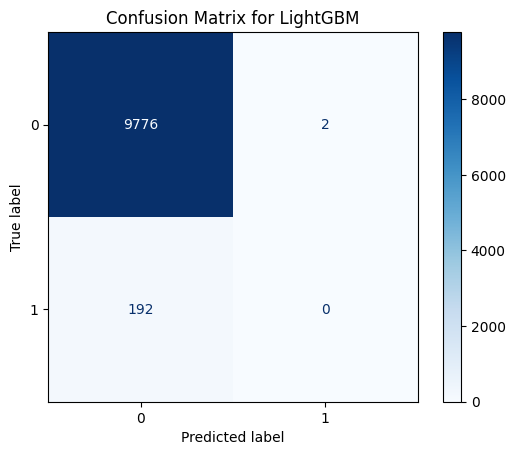

In [673]:
# Предсказания и построение матрицы ошибок
y_pred = best_model.predict(X_test)  # Предсказание классов
cm = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f"Confusion Matrix for {best_model_name}")
plt.show()

In [674]:
# Анализ метрик
tn, fp, fn, tp = cm.ravel()  # Разворачиваем матрицу ошибок
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Метрики для {best_model_name}:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Метрики для LightGBM:
Accuracy: 0.98
Precision: 0.00
Recall: 0.00
F1-Score: 0.00


# Вывод

Результаты модели показывают, что она превосходно справляется с идентификацией клиентов, которые **не собираются совершать покупку** — об этом свидетельствует высокое значение **True Negative (9776)**.

---

#### Значимость для бизнеса:
- Модель позволяет **эффективно определить клиентов, не планирующих покупку**.
- Это помогает направить **маркетинговые усилия на нужный сегмент**, увеличивая шансы конверсии.
- **Снижение издержек** на маркетинг для клиентов, которые и так готовы совершить покупку.

---

#### Ключевые инсайты:
1. **Фокус на непокупателях**: Компании смогут избегать трат на рекламу для клиентов, которые не нуждаются в дополнительном воздействии.
2. **Целевая стратегия**: Оптимизация усилий и ресурсов для работы с нерешительными клиентами.

---

Хотя текущая модель не предсказывает класс "покупка" (True Positive = 0), её способность точно выявлять "непокупателей" уже является мощным инструментом для формирования эффективных маркетинговых кампаний. Ориентировоность
- Ориентированность модели на непокупателей вероятнее всего объясняется сильным диссбалансов классов в target

Для улучшения работы с клиентами, готовыми к покупке, можно рассмотреть дальнейшую настройку модели, включая балансировку классов.